```
# This is formatted as code
```

#### VGG trained with video-->frame data

In [ ]:
from google.colab import drive
drive='drive'
drive.mount(f'/content/{drive}')

### Imports

In [ ]:
import os
import math
import time
# import zipfile 
import shutil
from random import shuffle
import numpy as np
import pandas as pd
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers
# from keras.layers import Dense, Activation, Flatten, Dropout 
from tensorflow.keras import Model 
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from google.colab.patches import cv2_imshow

np.random.seed(5)

## Creating train/test data

In [ ]:
base_folder =  '/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v3'
out_base_folder = '/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8'

#### Create folder if not present

In [ ]:
necc_folds = [
              out_base_folder,
              os.path.join(out_base_folder, 'train2'),
              os.path.join(out_base_folder, 'validation2'),
              os.path.join(out_base_folder, 'train2', 'front'),
              os.path.join(out_base_folder, 'train2', 'different'),
              os.path.join(out_base_folder, 'validation2', 'front'),
              os.path.join(out_base_folder, 'validation2', 'different'),
]
for fold in necc_folds:
    if not os.path.exists(fold):
        os.mkdir(fold)

In [ ]:
in_folds = [
              os.path.join(base_folder, 'train2', 'front'),
              os.path.join(base_folder, 'train2', 'different'),
              os.path.join(base_folder, 'validation2', 'front'),
              os.path.join(base_folder, 'validation2', 'different'),
]
out_folds = [
              os.path.join(out_base_folder, 'train2', 'front'),
              os.path.join(out_base_folder, 'train2', 'different'),
              os.path.join(out_base_folder, 'validation2', 'front'),
              os.path.join(out_base_folder, 'validation2', 'different'),
]

In [ ]:
!ls /content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8/
temp_all_frm_path = os.path.join(out_base_folder, 'all_frames')
print(temp_all_frm_path)
if not os.path.exists(temp_all_frm_path):
    os.mkdir(temp_all_frm_path)
    print('Created Dir.')

train2	validation2
/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8/all_frames
Created Dir.


### Video to Frames

In [ ]:
! ls /content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/pytube

Ashes_2021	 ICC_T20_2015  Individual_Vids	Ind_vs_WI_2019
cric_highlights  ICC_T20_2016  Ind_vs_Aus_2021	pytube_frames
full_match	 ICC_WC_2011   Ind_vs_Eng_2018	pytube_frames_cropped
hough_transform  ICC_WC_2019   Ind_vs_Eng_2021	yolo_annotations


In [ ]:
fl_list = pd.read_excel('/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/pytube_filelist.xlsx')
fl_list.head()

,series,index,orig_name
0,Ashes_2021,Ashes_2021_v1,Ashes_2021_Stokes Hits Ton But Aus Earn Draw ...
1,Ashes_2021,Ashes_2021_v2,Ashes_2021_Steve Smith Makes 144 On Test Retur...
2,Ashes_2021,Ashes_2021_v3,Ashes_2021_Smith Frustrates England Onslaught ...
3,Ashes_2021,Ashes_2021_v4,Ashes_2021_Smith & Wade Make England Toil The...
4,Ashes_2021,Ashes_2021_v5,Ashes_2021_Sensational Stokes 135 Wins Match ...


In [ ]:
# fl_list.series.unique()
fl_list2 = fl_list[fl_list['series'].isin(['Individual_Vids', 'cric_highlights'])]
fl_list2.shape

(134, 3)

In [ ]:
fl_list2.head()

,series,index,orig_name
229,Individual_Vids,Individual_Vids_v1,Individual_Vids_Wickets aplenty but India tick...
230,Individual_Vids,Individual_Vids_v2,Individual_Vids_T20 Classic Goes Right Down To...
231,Individual_Vids,Individual_Vids_v3,Individual_Vids_Second Test Australia v Englan...
232,Individual_Vids,Individual_Vids_v4,Individual_Vids_Rohit Sharma Hits 140! India ...
233,Individual_Vids,Individual_Vids_v5,Individual_Vids_Pandyas power seals series win...


#### Function to get frames

In [ ]:
def getVidFrames(vid_name, out_fld, vid_idx):
    cap = cv2.VideoCapture(vid_path)
    if (cap.isOpened() == False):
        print("Error opening the video file")
    # Read fps and frame count
    else:
        # Get frame rate information
        # You can replace 5 with CAP_PROP_FPS as well, they are enumerations
        fps = cap.get(5)
        print('Frames per second : ', fps,'FPS')

        # Get frame count
        # You can replace 7 with CAP_PROP_FRAME_COUNT as well, they are enumerations
        frame_count = cap.get(7)
        print('Frame count : ', frame_count)
    
    start_time = time.time()
    cnt = 0
    
    # Read until video is completed
    while(cap.isOpened()):
        # print(cnt, ' --> ', cnt % fps )
        # Capture frame-by-frame
        ret, frame = cap.read()
        # if cnt==501:
        #     break
        if ret == True:
            if cnt % math.ceil(fps)!=0:
                cnt += 1
                continue
            if cnt % 1000 == 0:
                    print(cnt)
            #removing scorecard
            roi = frame
            roi = roi[:int(roi.shape[0] * 0.85),:]
            # cropping center of an image
            thresh=1/4 
            end = roi.shape[1] - int(roi.shape[1]*thresh)
            start = int(roi.shape[1]*thresh)
            roi = roi[:,start:end]
            frame = roi
            cv2.imwrite(os.path.join(out_fld, f'{vid_idx}_{str(cnt)}.jpg'), frame)
            print('writing ', f'{vid_idx}_{str(cnt)}.jpg', '----', time.time()-start_time)
            cnt += 1
        else:
            break

    cv2.destroyAllWindows()
    return

In [ ]:
%%time
base_path = '/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/pytube'
vid_path_tup = list(zip(fl_list2['series'], fl_list2['orig_name'], fl_list2['index']))
start_time = time.time()
for i, item in enumerate(vid_path_tup):
    # print(item)
    # if i<=16:
    #     continue
    vid_path = os.path.join(base_path, item[0], item[1])
    print(i, vid_path)
    # getVidFrames(vid_path_tup, temp_all_frm_path, item[2])
    # print(item)
    # print(time.time()-start_time)
    # if i==23:
    #     break

In [ ]:
from glob import glob
fl_list = glob('/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8/all_frames/*')
len(fl_list)

18387

In [ ]:
# !ls /content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8/all_frames
# len(os.listdir('/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8/all_frames'))
# os.path.exists('/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8/all_frames')
print(fl_list[:5])
fl_name = [x.split('/')[-1] for x in fl_list]
fl_name = [x.split('.jpg')[0] for x in fl_name]
fl_name[:5]

['/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8/all_frames/Individual_Vids_v23_9250.jpg', '/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8/all_frames/Individual_Vids_v23_9275.jpg', '/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8/all_frames/Individual_Vids_v23_9300.jpg', '/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8/all_frames/Individual_Vids_v23_9325.jpg', '/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8/all_frames/Individual_Vids_v23_9350.jpg']


['Individual_Vids_v23_9250',
 'Individual_Vids_v23_9275',
 'Individual_Vids_v23_9300',
 'Individual_Vids_v23_9325',
 'Individual_Vids_v23_9350']

In [ ]:
def getDataKMeans(fname):
    img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
    roi = img
    thresh=1/4 
    end = roi.shape[1] - int(roi.shape[1]*thresh)
    start = int(roi.shape[1]*thresh)
    roi = roi[:,start:end]
    rs = cv2.resize(roi, (int(roi.shape[1]/10), int(roi.shape[0]/10)))
    fl_img = rs.flatten()
    return fl_img

In [ ]:
%%time
in_data = {
    # 'name': []
}
for i, f in enumerate(fl_name):
    # if i==5:
    #     break
    in_fld = '/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8/all_frames/'
    fname = os.path.join(in_fld, f'{f}.jpg')
    print(fname)
    temp_ = getDataKMeans(fname)
    in_data[f] = temp_

In [ ]:
import pickle

# with open('/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8/all_frame_dataDict.pkl', 'wb') as handle:
#     pickle.dump(in_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

# print(a == b)

In [ ]:
in_df = pd.DataFrame.from_dict(in_data, orient='index')
in_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951
Individual_Vids_v23_9250,106,106,106,104,104,106,104,105,102,102,...,94.0,94.0,94.0,94.0,95.0,95.0,95.0,95.0,95.0,95.0
Individual_Vids_v23_9275,92,91,87,85,86,87,91,93,93,93,...,86.0,86.0,86.0,84.0,84.0,86.0,85.0,85.0,81.0,88.0
Individual_Vids_v23_9300,66,55,59,62,97,109,100,88,74,82,...,36.0,37.0,31.0,40.0,31.0,38.0,119.0,109.0,104.0,109.0
Individual_Vids_v23_9325,55,66,87,83,78,76,77,102,110,120,...,47.0,59.0,53.0,41.0,26.0,37.0,41.0,40.0,114.0,105.0
Individual_Vids_v23_9350,88,89,89,-55,88,89,89,89,89,89,...,93.0,95.0,95.0,102.0,105.0,104.0,103.0,103.0,97.0,96.0


### KMeans Clustering
 - https://www.analyticsvidhya.com/blog/2021/04/k-means-clustering-simplified-in-python/
 - https://realpython.com/k-means-clustering-python/#how-to-build-a-k-means-clustering-pipeline-in-python

In [ ]:
# standardization
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
# define standard scaler
scaler = StandardScaler()
# transform data
scaled = scaler.fit_transform(in_df)
print(scaled)
in_scaled = pd.DataFrame(scaled, index=in_df.index, columns=in_df.columns)
in_scaled.head()

[[ 0.9166492   0.91479451  0.90982834 ... -0.50769835 -0.50643322
  -0.48461377]
 [ 0.74612512  0.731697    0.67700951 ... -0.70492219 -0.78467479
  -0.62520061]
 [ 0.42943756  0.29226295  0.33390806 ... -0.23158497 -0.32756363
  -0.2034401 ]
 ...
 [-1.90917828 -1.91711376 -1.93301219 ...  0.12341795  0.10967312
   0.01748208]
 [-1.84827683 -1.85608126 -1.87174408 ...  0.49814325  0.40778909
   0.33882343]
 [-1.84827683 -1.84387476 -1.8839977  ...  0.47842087  0.40778909
   0.41915876]]


,0,1,2,3,4,5,6,7,8,9,...,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951
Individual_Vids_v23_9250,0.916649,0.914795,0.909828,0.891731,0.897747,0.917481,0.901073,0.911232,0.875873,0.876781,...,-0.488884,-0.492435,-0.491975,-0.507925,-0.492997,-0.516501,-0.508518,-0.507698,-0.506433,-0.484614
Individual_Vids_v23_9275,0.746125,0.731697,0.677010,0.659109,0.678526,0.685137,0.742452,0.764939,0.766313,0.767195,...,-0.643690,-0.647784,-0.646031,-0.701865,-0.710022,-0.694612,-0.706095,-0.704922,-0.784675,-0.625201
Individual_Vids_v23_9300,0.429438,0.292263,0.333908,0.377515,0.812494,0.954167,0.852267,0.703984,0.535019,0.633256,...,-1.611230,-1.599295,-1.705168,-1.555198,-1.755687,-1.644539,-0.034336,-0.231585,-0.327564,-0.203440
Individual_Vids_v23_9325,0.295454,0.426534,0.677010,0.634623,0.581094,0.550622,0.571629,0.874659,0.973260,1.095954,...,-1.398371,-1.172086,-1.281513,-1.535804,-1.854335,-1.664329,-1.575429,-1.592429,-0.128820,-0.283775
Individual_Vids_v23_9350,0.697404,0.707284,0.701517,-1.054941,0.702884,0.709594,0.718049,0.716175,0.717619,0.718490,...,-0.508235,-0.473016,-0.472718,-0.352774,-0.295702,-0.338390,-0.350458,-0.349919,-0.466684,-0.464530


In [ ]:
wcss=[]
for i in range(2,7):
    kmeans = KMeans(i)
    kmeans.fit(in_scaled)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

number_clusters = range(2,7)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

ValueError: ignored

In [ ]:
arr_len = [len(val) for (key, val) in in_data.items()]
print(set(arr_len))
# {1464, 1952}

{1952, 1464}


In [ ]:
in_data_v1 = {x: in_data[x] for x in in_data if len(in_data[x])==1952}
print(len(in_data_v1))
in_data_v2 = {x: in_data[x] for x in in_data if len(in_data[x])==1464}
print(len(in_data_v2))

15045
3342


In [ ]:
def mdlKMeans():
    return

In [ ]:
in_df.isnull().sum()

0          0
1          0
2          0
3          0
4          0
        ... 
1947    3342
1948    3342
1949    3342
1950    3342
1951    3342
Length: 1952, dtype: int64

In [ ]:
temp_dict = in_data_v2
in_df = pd.DataFrame.from_dict(temp_dict, orient='index')
print(in_df.shape)
# define standard scaler
scaler = StandardScaler()
# transform data
scaled = scaler.fit_transform(in_df)
print(scaled.shape)
in_scaled = pd.DataFrame(scaled, index=in_df.index, columns=in_df.columns)
# in_scaled.head()

# wcss=[]
# for i in range(2,7):
#     kmeans = KMeans(i)
#     kmeans.fit(in_scaled)
#     wcss_iter = kmeans.inertia_
#     wcss.append(wcss_iter)

# number_clusters = range(2,7)
# plt.plot(number_clusters,wcss)
# plt.title('The Elbow title')
# plt.xlabel('Number of clusters')
# plt.ylabel('WCSS')

(3342, 1464)
(3342, 1464)


In [ ]:
kmeans = KMeans(6)
identified_clusters = kmeans.fit_predict(in_scaled)
# identified_clusters
# array([1, 1, 0, 0, 0, 2])
data_with_clusters = in_scaled.copy()
data_with_clusters['Clusters'] = identified_clusters 

In [ ]:
import pickle

pkl_name = '/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8/kmeans_v2.pkl'
print(pkl_name)
with open(pkl_name, 'wb') as handle:
    pickle.dump(data_with_clusters, handle, protocol=pickle.HIGHEST_PROTOCOL)

/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8/kmeans_v2.pkl


In [ ]:
fl_cp_dict = dict(zip(data_with_clusters.index, data_with_clusters['Clusters']))
print(len(fl_cp_dict))

data_with_clusters['Clusters'].unique().tolist()
base_path = '/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8'
for i in data_with_clusters['Clusters'].unique().tolist():
    fld_path = os.path.join(base_path, 'kmeans_v2', str(i))
    print(fld_path)
    if not os.path.exists(fld_path):
        os.mkdir(fld_path)

3342
/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8/kmeans_v2/5
/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8/kmeans_v2/1
/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8/kmeans_v2/4
/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8/kmeans_v2/2
/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8/kmeans_v2/3
/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8/kmeans_v2/0


In [ ]:
%%time
cnt = 0
for key, val in fl_cp_dict.items():
    # print(key, val)
    print(cnt)
    in_fld = f'{base_path}/all_frames/'
    src = os.path.join(in_fld, f'{key}.jpg')
    dest = os.path.join(base_path, 'kmeans_v2', str(val), f'{key}.jpg')
#     print(src)
#     print(dest)
    shutil.copy(src, dest)
    cnt += 1
#     if cnt == 10:
#         break

### Canny - HoughP transform function

In [ ]:
def getCannyHoughP(roi):
    # Convert the image to gray-scale
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = roi
    # Find the edges in the image using canny detector
    # edges = cv2.Canny(gray, threshold1=100, threshold2=200, aperture_size=3, L2Gradient=False)
    edges = cv2.Canny(gray, 100, 200)
    # plt.figure(figsize = (10,7))
    # plt.imshow(edges)#, aspect='auto'

    img_phough = edges.copy()
    # Detect points that form a line
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 50, minLineLength=10, maxLineGap=250)
    # Draw lines on the image
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(img_phough, (x1, y1), (x2, y2), (255, 0, 0), 3)
    # # Show result
    # # plt.figure(figsize = (10,7))
    # # plt.imshow(img_phough)
    return (edges, img_phough)

### Create training data - Canny-HoughP

In [ ]:
%%time
for i, path in enumerate(in_folds):
    # path = os.path.join(base_folder, 'train2', 'front')
    print(path)
    frame_path = out_folds[i]
    print(frame_path)
    img_list = os.listdir(path)
    print(len(img_list))

    for j, filenm in enumerate(img_list):
        print(j, filenm)
        img = cv2.imread(os.path.join(path, filenm), cv2.IMREAD_UNCHANGED)
        # img = cv2.imread(os.path.join(path, filenm), cv2.IMREAD_GRAYSCALE)
        # thresh=1/4 
        # roi = img
        # end = roi.shape[1] - int(roi.shape[1]*thresh)
        # start = int(roi.shape[1]*thresh)
        # cropped = roi[:,start:end]
        # print(img.shape)
        # print(start, end)
        # cv2.imwrite(os.path.join(frame_path, filenm),cropped)
        # # cv2.imwrite(os.path.join(frame_path, filenm.split('.jpg')[0]+'_2.jpg'),img)
        roi = img
        canny, houghp = getCannyHoughP(roi)
        # print(houghp.shape)
        # canny = np.repeat(canny[:,:,None], 3, axis=2)
        houghp = np.repeat(houghp[:,:,None], 3, axis=2)
        # print(canny.shape)
        # plt.imshow(houghp, cmap='gray')
        # plt.show()
        # cv2.imwrite(os.path.join(frame_path, filenm),img)
        # cv2.imwrite(os.path.join(frame_path, filenm), canny)
        cv2.imwrite(os.path.join(frame_path, filenm), houghp)
        # plt.imshow(img)
        # cv2_imshow(img)
        # if j >= 20:
        #     break
    # if i == 0:
    #     break
## cropping center of an image
# cv2_imshow(img)
# cv2.waitKey(25)
# cv2.destroyAllWindows()
# cv2_imshow(cropped)
# cv2.waitKey(25)
# cv2.destroyAllWindows()

/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v3/train2/front
/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v7/train2/front
330
0 images - 2022-03-29T115327.565.jpg
1 download (105).jpg
2 images - 2022-03-29T115812.858.jpg
3 images - 2022-03-28T120422.285.jpg
4 images (195).jpg
5 images (294).jpg
6 images - 2022-03-29T115814.720.jpg
7 images - 2022-03-29T115835.141.jpg
8 images (256).jpg
9 images - 2022-03-29T115835.203.jpg
10 images - 2022-03-29T115819.233.jpg
11 images - 2022-03-29T115805.425.jpg
12 images - 2022-03-29T115318.835.jpg
13 download (97).jpg
14 images (198).jpg
15 images - 2022-03-29T115814.590.jpg
16 download (111).jpg
17 images (321).jpg
18 images - 2022-03-29T115821.877.jpg
19 download (71).jpg
20 images (257).jpg
21 images (309).jpg
22 download (95).jpg
23 images - 2022-03-29T115313.486.jpg
24 images - 2022-03-29T115816.498.jpg
25 images - 2022-03-29T115818.444.jpg
26 download (83).jpg
27 images (235).jpg
28 download (5).

In [ ]:
len(img_list)

151

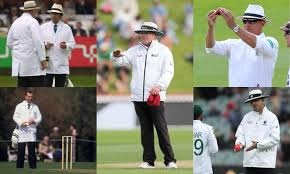

(174, 290, 3)
72 218


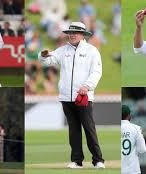

In [ ]:
cv2_imshow(img)
cv2.waitKey(25)
cv2.destroyAllWindows()
thresh=1/4 
roi = img
end = roi.shape[1] - int(roi.shape[1]*thresh)
start = int(roi.shape[1]*thresh)
print(img.shape)
print(start, end)
cropped = roi[:,start:end]
cv2_imshow(cropped)
cv2.waitKey(25)
cv2.destroyAllWindows()

In [ ]:

#### Data Prep

### Video to Frames

# !ls /mnt/d/Tiger/Open_Innovation/cv/drive_files/odi_match/

%%time
def save_frames(vname):
    # path = "/mnt/d/Tiger/Open_Innovation/cv/drive_files/odi_match/"
    path = dataset_dir
    # frame_path = f"/mnt/d/Tiger/Open_Innovation/cv/drive_files/pytube_frames/{vname}"
    frame_path = f'/content/{drive}/MyDrive/Open_Innov/Cricket_Analytics/data/pytube/pytube_frames/{vname}'

    if not os.path.exists(frame_path):
        os.makedirs(frame_path)
    video = os.path.join(path, f"{vname}.mp4")

    # Create a VideoCapture object and read from input file
    # If the input is the camera, pass 0 instead of the video file name
    cap = cv2.VideoCapture(video)
    cnt=0

    # Check if camera opened successfully
    if (cap.isOpened()== False): 
        print("Error opening video stream or file")
    else:
        # Get frame rate information
        # You can replace 5 with CAP_PROP_FPS as well, they are enumerations
        fps = cap.get(5)
        print('Frames per second : ', fps,'FPS')

        # Get frame count
        # You can replace 7 with CAP_PROP_FRAME_COUNT as well, they are enumerations
        frame_count = cap.get(7)
        print('Frame count : ', frame_count)

    ret,first_frame = cap.read()
    pred_result = {}

    # Read until video is completed
    while(cap.isOpened()):
        # Capture frame-by-frame
        ret, frame = cap.read()
            
        if ret == True:
            
            #removing scorecard
            # roi = frame[:600,:]
            roi = frame
            
            #cropping center of an image
            # thresh=400 
            # end = roi.shape[1] - thresh
            # roi = roi[:,thresh:end]
            
            # cv2.imshow("image",roi)
            # cv2_imshow(roi)
            # Press Q on keyboard to  exit
            # if cv2.waitKey(25) & 0xFF == ord('q'):
            #     break
            
            
            # pred_result[f] =  yhat
            if cnt%1000==0:
                print(os.path.join(frame_path, str(cnt)+'.jpg'))
            cv2.imwrite(os.path.join(frame_path, str(cnt)+'.jpg'),roi)
            cnt=cnt+1

            # if cnt >= 20:
            #     break
        # Break the loop
        else: 
            break

        cv2.destroyAllWindows()    
    return None

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11 µs


In [ ]:
# data_folder = '/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/transfer_learning/'
# data_folder = '/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v3'
# data_folder = '/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v6'
model_path = '/content/drive/MyDrive/Open_Innov/Cricket_Analytics/src/model'

In [ ]:
# os.listdir(data_folder)
fld_shot = os.listdir(os.path.join(data_folder, "shot_pics"))
fld_other = os.listdir(os.path.join(data_folder, "other_cricket_pics"))
print(len(fld_shot))
print(len(fld_other))
print(fld_shot[:5])
print(fld_other[:5])

In [ ]:
front_train = 950
front_valid = 650
diff_train = 950
diff_valid = 412
1362*0.7

In [ ]:
#### Copying pics from one folder to another
# %%time
# for i, f in enumerate(fld_shot):
#     if i < 950:
#         source = os.path.join(data_folder, 'shot_pics', f)
#         dest = os.path.join(data_folder, 'train/front', f)
#         new_path = shutil.copy(source, dest)
#     else:
#         source = os.path.join(data_folder, 'shot_pics', f)
#         dest = os.path.join(data_folder, 'validation/front', f)
#         new_path = shutil.copy(source, dest)
#     print(new_path)


In [ ]:
#### Copying pics from one folder to another
# %%time
# for i, f in enumerate(fld_other):
#     if i < 950:
#         source = os.path.join(data_folder, 'other_cricket_pics', f)
#         dest = os.path.join(data_folder, 'train/front', f)
#         new_path = shutil.copy(source, dest)
#     else:
#         source = os.path.join(data_folder, 'other_cricket_pics', f)
#         dest = os.path.join(data_folder, 'validation/front', f)
#         new_path = shutil.copy(source, dest)
#     print(i, new_path)


In [ ]:
#### File format change
%%time
img_list = os.listdir(train_nonshot_dir)
img_list = os.listdir(os.path.join(base_dir, 'train', 'different'))

for i, f in enumerate(img_list):
    image = cv2.imread(os.path.join(base_dir, 'train', 'different', f))
    cv2.imwrite(os.path.join(data_folder, "train2/different", f.replace(".jfif", ".jpg")), image)
    # cv2.imwrite(os.path.join(data_folder, "train2/front", img_list[0].replace(".jfif", ".jpg")), image)
    print(i, os.path.join(data_folder, "train2/different", f.replace(".jfif", ".jpg")))

### Data shuffle and train and test split

In [ ]:
# data_folder = '/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/transfer_learning/'
data_folder = '/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8'
# model_path = '/content/drive/MyDrive/Open_Innov/Cricket_Analytics/src/model'

In [ ]:
# os.listdir(data_folder)
fld_shot = os.listdir(os.path.join(data_folder, "shot"))
fld_other = os.listdir(os.path.join(data_folder, "different"))
print(len(fld_shot))
print(len(fld_other))
print(fld_shot[:5])
print(fld_other[:5])

2625
2625
['Individual_Vids_v10_5200.jpg', 'Individual_Vids_v10_5300.jpg', 'Individual_Vids_v10_5325.jpg', 'Individual_Vids_v10_5350.jpg', 'Individual_Vids_v10_5375.jpg']
['Individual_Vids_v7_5775.jpg', 'Individual_Vids_v7_5600.jpg', 'Individual_Vids_v7_5300.jpg', 'Individual_Vids_v7_5125.jpg', 'Individual_Vids_v7_5325.jpg']


In [ ]:
shuffle(fld_shot)
shuffle(fld_other)
print(len(fld_shot))
print(len(fld_other))
print(fld_shot[:5])
print(fld_other[:5])

2625
2625
['Individual_Vids_v7_625.jpg', 'Individual_Vids_v4_2425.jpg', 'Individual_Vids_v18_2825.jpg', 'Individual_Vids_v13_10800.jpg', 'Individual_Vids_v11_11825.jpg']
['Individual_Vids_v20_11200.jpg', 'Individual_Vids_v4_475.jpg', 'Individual_Vids_v2_4680.jpg', 'Individual_Vids_v5_9225.jpg', 'Individual_Vids_v14_17425.jpg']


In [ ]:
npics = 1800
front_train = npics
front_valid = len(fld_shot) - npics
diff_train = npics
diff_valid = len(fld_other) - npics
len(fld_shot) * 0.7

1837.4999999999998

In [ ]:
%%time
#### Copying pics from one folder to another
for i, f in enumerate(fld_shot):
    source = os.path.join(data_folder, 'shot', f)
    if i < npics:
        dest = os.path.join(data_folder, 'train2/front', f)
        new_path = shutil.copy(source, dest)
    else:
        dest = os.path.join(data_folder, 'validation2/front', f)
        new_path = shutil.copy(source, dest)
    if i%100==0:
        print('Front', new_path)
#### Copying pics from one folder to another
for i, f in enumerate(fld_other):
    source = os.path.join(data_folder, 'different', f)
    if i < npics:
        dest = os.path.join(data_folder, 'train2/different', f)
        new_path = shutil.copy(source, dest)
    else:
        dest = os.path.join(data_folder, 'validation2/different', f)
        new_path = shutil.copy(source, dest)
    if i%100==0:
        print('Different', new_path)


Front /content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8/train2/front/Individual_Vids_v7_625.jpg
Front /content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8/train2/front/Individual_Vids_v2_3720.jpg
Front /content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8/train2/front/Individual_Vids_v3_4125.jpg
Front /content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8/train2/front/Individual_Vids_v8_16290.jpg
Front /content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8/train2/front/Individual_Vids_v16_8375.jpg
Front /content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8/train2/front/Individual_Vids_v14_3300.jpg
Front /content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8/train2/front/Individual_Vids_v13_11075.jpg
Front /content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8/train2/front/Individual_Vids_v12_15950.jpg
Front /content/drive/MyDrive/Open_Innov/Cr

### VGG Model Training

In [ ]:
data_folder = '/content/drive/MyDrive/Open_Innov/Cricket_Analytics/data/shot_clasif_v8'
model_path = '/content/drive/MyDrive/Open_Innov/Cricket_Analytics/src/model'

In [ ]:
base_dir = os.path.join(data_folder)

train_dir = os.path.join(base_dir, 'train2')
validation_dir = os.path.join(base_dir, 'validation2')

# Directory with our training front pictures
train_fronts_dir = os.path.join(train_dir, 'front')

# Directory with our training nonshot pictures
train_nonshot_dir = os.path.join(train_dir, 'different')

# Directory with our validation front pictures
validation_fronts_dir = os.path.join(validation_dir, 'front')

# Directory with our validation nonshot pictures
validation_nonshot_dir = os.path.join(validation_dir, 'different')

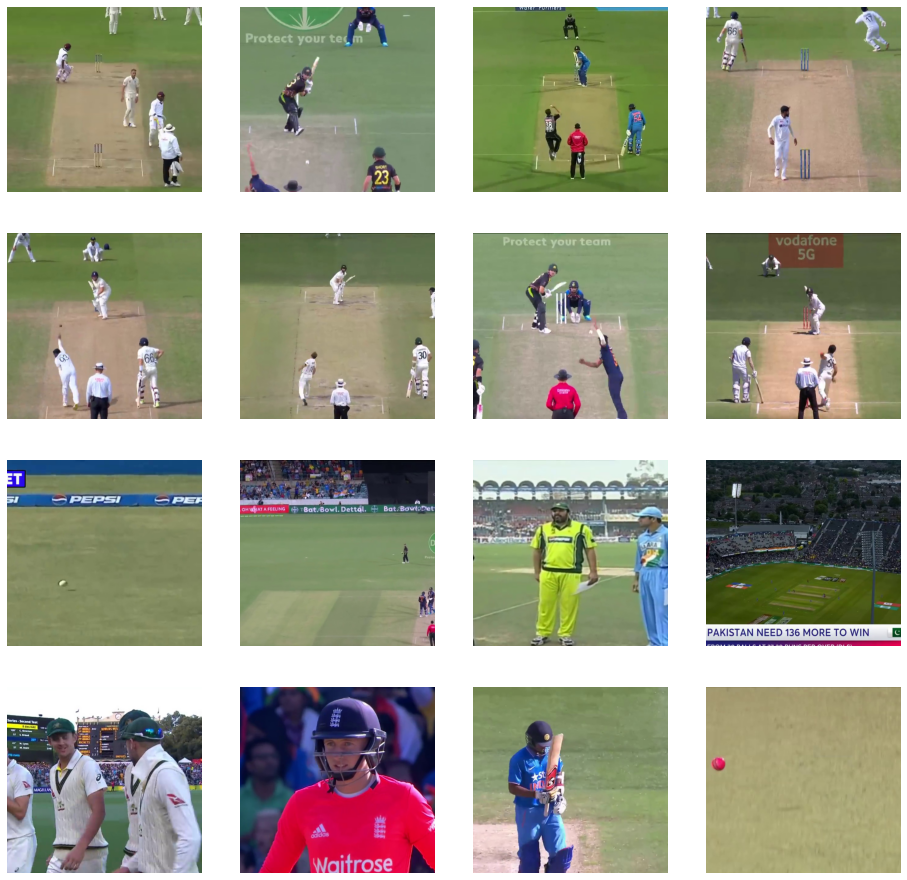

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.image as mpimg
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_front_fnames = os.listdir( train_fronts_dir )
train_nonshot_fnames = os.listdir( train_nonshot_dir )


next_front_pix = [os.path.join(train_fronts_dir, fname) 
                for fname in train_front_fnames[ pic_index-8:pic_index] 
               ]

next_nonshot_pix = [os.path.join(train_nonshot_dir, fname) 
                for fname in train_nonshot_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_front_pix+next_nonshot_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

#### Step 1: Image Augmentation

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1.0/255. )

#### Step 2: Training and Validation Sets

In [ ]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 50, class_mode = 'binary', target_size = (224, 224))

# Flow validation images in batches of 20 using test_datagen generator
# validation_generator = test_datagen.flow_from_directory(validation_dir,  batch_size = 20, class_mode = 'binary', target_size = (224, 224))
validation_generator = test_datagen.flow_from_directory(validation_dir,  batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Found 3600 images belonging to 2 classes.
Found 1650 images belonging to 2 classes.


In [ ]:
# Your problem stems from the fact that the parameters steps_per_epoch and validation_steps 
# need to be equal to the total number of data points divided by the batch_size.

# batch_size=20
# steps_per_epoch = 100
# # validation_steps 

#### Step 3: Loading the Base Model
We will be using only the basic models, with changes made only to the final layer. This is because this is just a binary classification problem while these models are built to handle up to 1000 classes.

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
# base_model = VGG16(input_shape = (224, 224, 1), # Shape of our images
include_top = False, # Leave out the last fully connected layer
# weights = None) #For Grayscale
weights = 'imagenet')# For RGB

58900480/58889256 [==============================] - 0s 0us/step


#### Make Base model layers Untrainable
Since we don’t have to train all the layers, we make them non_trainable:

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

#### Step 4: Compile and Fit
We will then build the last fully-connected layer. I have just used the basic settings, but feel free to experiment with different values of dropout, and different Optimisers and activation functions.

In [ ]:
FC_LAYERS = [1024, 512, 256]
dropout = 0.5
NUM_EPOCHS = 20

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
for fc in FC_LAYERS:
    print(fc)
    x = layers.Dense(fc, activation='relu')(x)
    x = layers.Dropout(dropout)(x)

# x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
# x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

1024
512
256


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


We will now build the final model based on the training and validation sets we created earlier. Please note to use the original directories itself instead of the augmented datasets I have used below. I have used just 10 epochs, but you can also increase them to get better results:

In [ ]:
{
 'vgg16_epc_100_add_fc_lyr_v5': 'Grayscale images trained with model of 3 channels-RGB',
 'vgg16_epc_100_add_fc_lyr_v6': 'Grayscale images trained with model of 1 channel-Grayscale',
 'vgg16_canny_v7': 'Grayscale images trained with model of 3 channel-Canny',
 'vgg16_houghp_v8': 'Grayscale images trained with model of 3 channel-HoughP',
 'vgg16_vid2frm_v1': 'RGB image from videos'
}

{'vgg16_canny_v7': 'Grayscale images trained with model of 3 channel-Canny',
 'vgg16_epc_100_add_fc_lyr_v5': 'Grayscale images trained with model of 3 channels-RGB',
 'vgg16_epc_100_add_fc_lyr_v6': 'Grayscale images trained with model of 1 channel-Grayscale',
 'vgg16_houghp_v8': 'Grayscale images trained with model of 3 channel-HoughP',
 'vgg16_vid2frm_v1': 'RGB image from videos'}

In [ ]:
# %%time
# vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 20, epochs = EPOCHS, callbacks=callbacks)

In [ ]:
# %%time
EPOCHS = 50
# checkpoint_filepath = os.path.join(model_path, 'vgg16_epc_100_add_fc_lyr_v3_2nd_run')
mdl_nm = 'vgg16_vid2frm_v1'
checkpoint_filepath = os.path.join(model_path, mdl_nm)
if not os.path.exists(checkpoint_filepath):
    os.mkdir(checkpoint_filepath)
checkpoint_filepath = os.path.join(model_path, mdl_nm, 'weights_{epoch:05d}_{acc:.5f}')
# weights.{epoch:02d}-{val_loss:.2f}.hdf5
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    # save_weights_only=True,
    monitor='acc',
    mode='max',
    save_best_only=True, verbose=1)
# checkpoint = ModelCheckpoint(args["weights"], monitor="val_loss",
# 	save_best_only=True, verbose=1)
callbacks = [checkpoint]
# model = tf.keras.models.load_model(os.path.join(model_path, 'vgg16_epc_100_add_fc_lyr_v4'))

In [ ]:
from tensorflow import keras

In [ ]:
# %%time
mod_ref_path = '/content/drive/MyDrive/Open_Innov/Cricket_Analytics/'
model = keras.models.load_model(os.path.join(mod_ref_path, "src/model/vgg16_vid2frm_v1", 'weights_0017_0.9706'))
vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 72, epochs = EPOCHS, callbacks=callbacks)

Epoch 1/50
72/72 [==============================] - ETA: 0s - loss: 0.1486 - acc: 0.9614 
Epoch 1: acc improved from -inf to 0.96139, saving model to /content/drive/MyDrive/Open_Innov/Cricket_Analytics/src/model/vgg16_vid2frm_v1/weights_00001_0.96139
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Open_Innov/Cricket_Analytics/src/model/vgg16_vid2frm_v1/weights_00001_0.96139/assets
72/72 [==============================] - 3476s 48s/step - loss: 0.1486 - acc: 0.9614 - val_loss: 0.1413 - val_acc: 0.9655
Epoch 2/50
72/72 [==============================] - ETA: 0s - loss: 0.1148 - acc: 0.9686
Epoch 2: acc improved from 0.96139 to 0.96861, saving model to /content/drive/MyDrive/Open_Innov/Cricket_Analytics/src/model/vgg16_vid2frm_v1/weights_00002_0.96861
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Open_Innov/Cricket_Analytics/src/model/vgg16_vid2frm_v1/weights_00002_0.96861/assets
72/72 [==============================] - 109s 2s/step - loss: 0.1148 - acc: 0.9686 - val

In [ ]:
model.save(os.path.join(model_path, 'vgg16_vid2frm_v1', 'weights_30_final'))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Open_Innov/Cricket_Analytics/src/model/vgg16_epc_100_add_fc_lyr_v3_notBest_final/weights_100_0.9658/assets
